# LSTM part
## 1. Review 
 &emsp;&emsp;<font face="微软雅黑" size=3>TILL `2022.7.22`, I've done some basic tasks of my part and planned for this week's work.</font>
### 1.1 Work done
* <font face="微软雅黑" size=3>LSTM demo</font>


* <font face="微软雅黑" size=3>Different types of training methods</font>


### 1.2 Plan
* <font face="微软雅黑" size=3>Deploy the LSTM model to our online system</font>


* <font face="微软雅黑" size=3>Try to tackle the prediction-lag of LSTM</font>

## 2. Advance
### 2.1 Solution of prediction-lag
<br>

<font face="微软雅黑" size=3>Use **Method of Difference** can partly alleviate the prediction-lag. The prediction-lag is caused by the <br>instability of the data series and the **Method of Difference** reduce irregular fluctuations between data,<br> so I use LSTM predict the difference between data and finally solve this problem to some degree</font>

### 2.2 Extension of prediction window
<br>

<font face="微软雅黑" size=3>I extend prediction window from `1-day` to `5-days` by slide window</font>
![avatar](slide_window.png)


### 2.3 Deployment of LSTM
<br>

<font face="微软雅黑" size=3>Final version of LSTM & Pre-trained models for different stocks</font>
<br><br>

In [5]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import datetime

start=datetime.datetime(2018, 1, 1)
end=datetime.datetime(2022, 7, 1)
df = data.DataReader('NFLX', start=start, end=end, data_source='yahoo')

df=df.sort_index(ascending=True)
 
df=df[["Open","Close","High","Low"]]

### difference method
df_diff=df.diff().dropna()
df_diff.head(6)

,Open,Close,High,Low
Date,,,,
2018-01-03,5.949997,3.979996,4.560013,6.080002
2018-01-04,4.149994,0.580002,0.839996,2.500000
2018-01-05,1.050003,4.360001,2.970001,1.589996
2018-01-08,2.770004,2.059998,2.479996,2.850006
2018-01-09,2.089996,-2.740005,0.479996,0.149994
2018-01-10,-4.539993,3.210007,0.660004,-1.679993


In [6]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import numpy as np
from torch.autograd import Variable
import os
from torchvision import transforms
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

 
total_len=df_diff.shape[0]
sequence=5
X=[]
Y=[]
baseline=[]
date=[]
for i in range(total_len-sequence):
    X.append(np.array(df_diff.iloc[i:(i+sequence),1].values,dtype=np.float32).reshape(-1,1))
    Y.append(np.array(df_diff.iloc[(i+sequence),1],dtype=np.float32))
    baseline.append(np.array(df.iloc[(i+sequence),1],dtype=np.float32))
 
class Mydataset(Dataset):
 
    def __init__(self,ini_x,ini_y,transform=None):
        self.x=ini_x
        self.y=ini_y
        self.tranform = transform
 
    def __getitem__(self,index):
        x1=self.x[index]
        y1=self.y[index]
        if self.tranform !=None:
            return self.tranform(x1),y1
        return x1,y1
 
    def __len__(self):
        return len(self.x)
 
 
trainx,trainy=X[:int(0.7*total_len)],Y[:int(0.7*total_len)]
testx,testy=X[int(0.7*total_len):],Y[int(0.7*total_len):]
testbase=baseline[int(0.7*total_len):]

print(trainx[0])
print(trainy[0])
print(testbase[0])

train_loader=DataLoader(dataset=Mydataset(trainx,trainy,transform=transforms.ToTensor()), batch_size=12, shuffle=True)
test_loader=DataLoader(dataset=Mydataset(testx,testy), batch_size=1, shuffle=False)

[[ 3.9799957 ]
 [ 0.58000183]
 [ 4.3600006 ]
 [ 2.0599976 ]
 [-2.7400055 ]]
3.2100067
511.29


In [7]:
class lstm(nn.Module):
 
    def __init__(self,input_size=5,hidden_size=32,output_size=1):
        super(lstm, self).__init__()
        self.hidden_size=hidden_size
        self.input_size=input_size
        self.output_size=output_size
        self.rnn=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,batch_first=True)
        self.linear=nn.Linear(self.hidden_size,self.output_size)
 
 
    def forward(self,x):
        out,(hidden,cell)=self.rnn(x)
        a, b, c = hidden.shape
        out=self.linear(hidden.reshape(a*b,c))
        return out

model=lstm(input_size=1,hidden_size=32,output_size=1) 
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.005, weight_decay=1e-4)
 
preds=[]
labels=[]
for i in range(500):
    total_loss=0
    for idx,(data,label) in enumerate(train_loader):
        data1=data.squeeze(1)
        pred=model(Variable(data1))
        label=label.unsqueeze(1)
        loss=criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    print(i+1,"Loss: ",total_loss)

preds=[]
labels=[]
for idx, (x, label) in enumerate(test_loader):
    pred=model(x)
    preds.extend(pred.data.squeeze(1).tolist())
    labels.extend(label.tolist())

torch.save(model.state_dict(),"model_collection2/GOOG.pth")

1 Loss:  7212.481496810913
2 Loss:  7161.44337272644
3 Loss:  7133.6296043396
4 Loss:  7110.020192146301
5 Loss:  7061.597685337067
6 Loss:  6996.774217605591
7 Loss:  6911.9200439453125
8 Loss:  6789.465208053589
9 Loss:  6702.629375457764
10 Loss:  6587.927600860596
11 Loss:  6416.205305099487
12 Loss:  6270.793569564819
13 Loss:  6104.9879722595215
14 Loss:  5835.969153404236
15 Loss:  5670.422636985779
16 Loss:  5473.05889415741
17 Loss:  5257.378189086914
18 Loss:  5052.338607788086
19 Loss:  4810.168027877808
20 Loss:  4660.905384063721
21 Loss:  4321.932349205017
22 Loss:  4079.0050745010376
23 Loss:  3931.0701303482056
24 Loss:  3675.263547897339
25 Loss:  3448.2240500450134
26 Loss:  3239.223370075226
27 Loss:  3123.106867790222
28 Loss:  2954.2471408843994
29 Loss:  2775.1592864990234
30 Loss:  2587.875657081604
31 Loss:  2473.467405319214
32 Loss:  2341.0722184181213
33 Loss:  2224.1321816444397
34 Loss:  2004.1254839897156
35 Loss:  1920.8185019493103
36 Loss:  1781.9648787

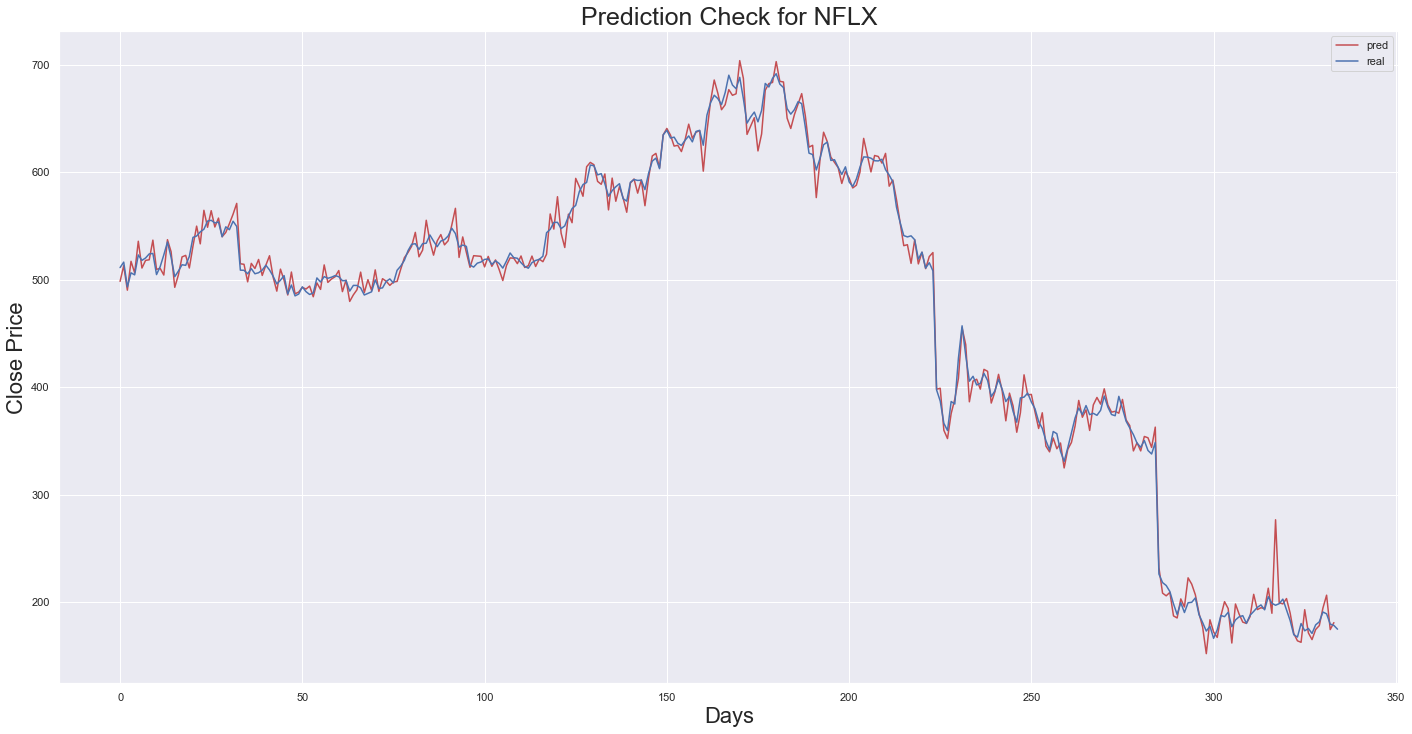

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn; seaborn.set()

pred=pd.DataFrame(preds,columns=["Close"])
label=pd.DataFrame(labels,columns=["Close"])
base_line=pd.DataFrame(testbase,columns=["Close"])
train_shift = base_line["Close"].shift(1)
predi = pred["Close"].add(train_shift).dropna()

predict = predi.values.tolist()
real = testbase

import matplotlib as mpl
mpl.rc('figure', figsize=(24, 12))
mpl.__version__
plt.title('Prediction Check for NFLX', fontsize=25)
plt.xlabel("Days",fontsize=22)
plt.ylabel("Close Price",fontsize=22)
plt.plot(predict,"r",label="pred")
plt.plot(real,"b",label="real")

plt.legend()
plt.show()